In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
num_epochs = 5
batch_size = 40
learning_rate = 0.001
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

cuda


In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"



In [5]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize( 
       (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) 
    )
])
train_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = True,
    download =True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset
    , batch_size = batch_size
    , shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset
    , batch_size = 256
    , shuffle = True)
n_total_step = len(train_loader)
print(n_total_step)


In [ ]:
import torch.backends.cudnn as cudnn
import random


torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)
cudnn.benchmark = False
cudnn.deterministic = True
random.seed(0)

In [ ]:
model = torch.load("cifar-10.pth")

In [ ]:
def normalize_max1(w):
    for i in range(len(w)):
        w[i] = w[i] / torch.max(abs(w[i]))
    return w

to_gaussian = lambda arr, mean = 1, std = 1: ((arr - torch.mean(arr))/ (torch.std(arr) + 0.00001)) * std + mean

softmax = torch.nn.Softmax(dim=1)
softmax2d = lambda b: softmax(torch.flatten(b, start_dim = 1)).reshape(b.shape)
f2 = lambda w, _=None: softmax2d(normalize_max1(-w)) * len(w[0])


In [329]:
from tqdm import tqdm

optimizer = torch.optim.SGD(model.parameters(), lr = 0.0, momentum=0.9,weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

f2 = lambda w, _=None: softmax2d(normalize_max1(-w)) * len(w[0])

correct_before, correct_after, all = 0,0, 0

# 맞았다 틀린 애들
uncorrect_dict = {
    "img_before": [],
    "img_after" : [],
    "softlabel_before" : [],
    "softlabel_after": [],
    "real_label" : [],
    "lrp" : []
}

# 또 틀린 애들
uncorrect_sp_dict = {
    "img_before": [],
    "img_after" : [],
    "softlabel_before" : [],
    "softlabel_after": [],
    "real_label" : [],
    "lrp" : []
}

# 틀렸다 맞은 애들
correct_dict = {
    "img_before": [],
    "img_after" : [],
    "softlabel_before" : [],
    "softlabel_after": [],
    "real_label" : [],
    "lrp" : []
}


for idx, batch in enumerate(tqdm(test_loader)):
    img , label = batch[0].cuda(), batch[1].cuda()

    img.requires_grad = True
    img.retain_grad = True

    fake_label = torch.ones_like(label)

    output = model(img)
    output_arg = torch.argmax(output, dim=1)
    fake_label = (fake_label + output_arg) % 1000

    loss = criterion(output, label)
    loss.backward()
    comp = (label == torch.argmax(output, dim=1))
    correct_before += sum(comp).item()

    correct_idx2 = torch.where(comp == 1)
    un_correct_idx2 = torch.where(comp == 0)
    optimizer.zero_grad()

    img_lrp = (img*img.grad).clone()
    img_lrp = f2(img_lrp)
    
    with torch.no_grad():
        for i in range(len(img_lrp)):
            img_lrp[i] = to_gaussian(img_lrp[i], std = 0.1)

        img_lrp = img*img_lrp # img_lrp가 음수값인것 지움
        output2 = model(img_lrp)

        all += len(label)
        
        comp2 = (label == torch.argmax(output2, dim=1))
        correct_after += sum(comp2).item()
        
        correct_idx2 = torch.where(comp2 == 1)
        uncorrect_idx2 = torch.where(comp2 == 0)
        
        
        NN_idx = ((comp+1) % 2) * ((comp2 + 1) % 2) # 둘다 틀림
        CN_idx = comp * ((comp2 + 1) % 2) # 맞고 틀림
        NC_idx = ((comp+1) % 2) * comp2 # 틀리고 맞음
        

        for idx in torch.where(NN_idx==1)[0].detach().cpu().numpy():
            uncorrect_sp_dict['lrp'].append(img[idx]*img.grad[idx])
            uncorrect_sp_dict['img_before'].append(img[idx].detach().cpu())
            uncorrect_sp_dict['img_after'].append(img_lrp[idx].detach().cpu())
            uncorrect_sp_dict['softlabel_before'].append(output[idx].detach().cpu())
            uncorrect_sp_dict['softlabel_after'].append(output2[idx].detach().cpu())
            uncorrect_sp_dict['real_label'].append(label[idx].detach().cpu())

        for idx in torch.where(CN_idx==1)[0].detach().cpu().numpy():
            uncorrect_dict['lrp'].append(img[idx]*img.grad[idx])
            uncorrect_dict['img_before'].append(img[idx].detach().cpu())
            uncorrect_dict['img_after'].append(img_lrp[idx].detach().cpu())
            uncorrect_dict['softlabel_before'].append(output[idx].detach().cpu())
            uncorrect_dict['softlabel_after'].append(output2[idx].detach().cpu())
            uncorrect_dict['real_label'].append(label[idx].detach().cpu())

        for idx in torch.where(NC_idx==1)[0].detach().cpu().numpy():
            correct_dict['lrp'].append(img[idx]*img.grad[idx])
            correct_dict['img_before'].append(img[idx].detach().cpu())
            correct_dict['img_after'].append(img_lrp[idx].detach().cpu())
            correct_dict['softlabel_before'].append(output[idx].detach().cpu())
            correct_dict['softlabel_after'].append(output2[idx].detach().cpu())
            correct_dict['real_label'].append(label[idx].detach().cpu())


print('Accuracy(teacher) : %.4f' % (correct_before/all))
print('Accuracy(student) : %.4f' % (correct_after/all))


100%|██████████| 40/40 [02:55<00:00,  4.38s/it]

Accuracy(teacher) : 0.9304
Accuracy(student) : 0.9971


In [564]:
len(uncorrect_sp_dict['img_before']), len(uncorrect_dict['img_before']), len(correct_dict['img_before'])

(29, 0, 667)

tensor(0.7247)

In [62]:
from matplotlib import pyplot as plt

## label 변화

In [63]:
torch.argmax(correct_dict['softlabel_before'][i])

tensor(0)

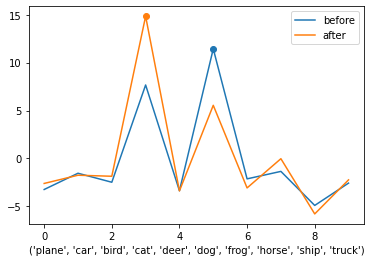

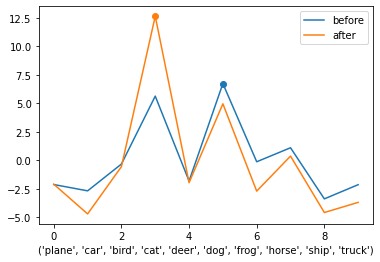

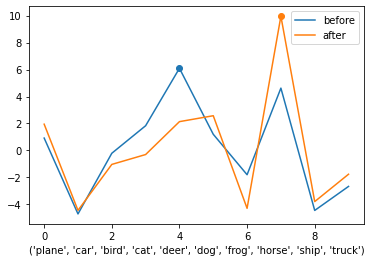

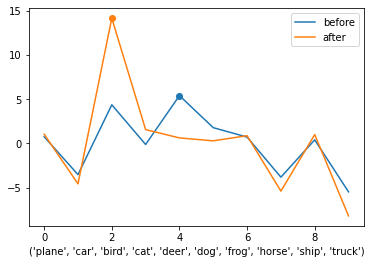

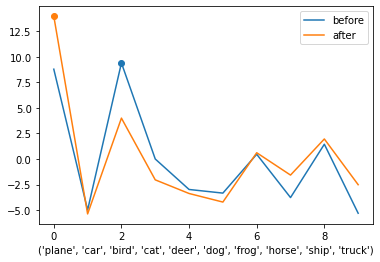

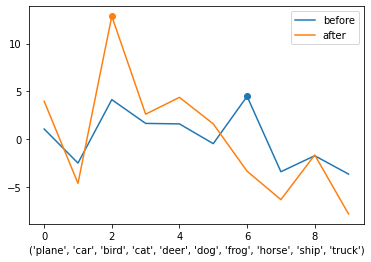

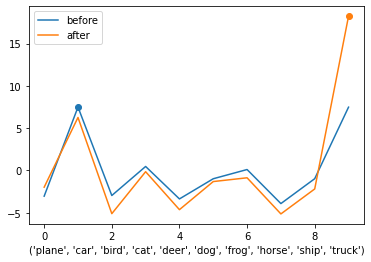

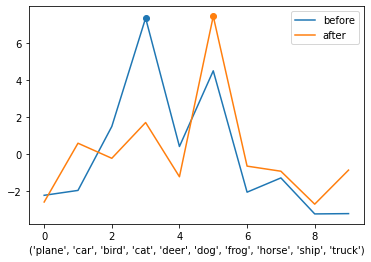

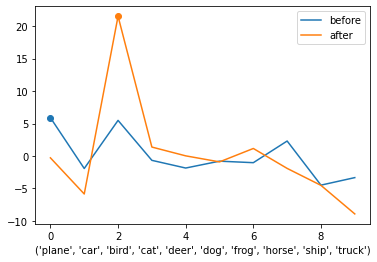

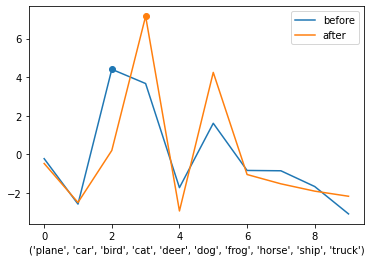

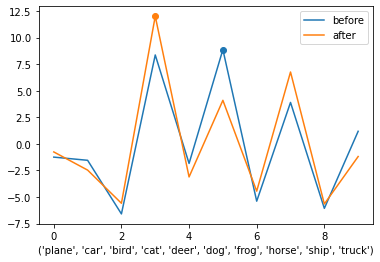

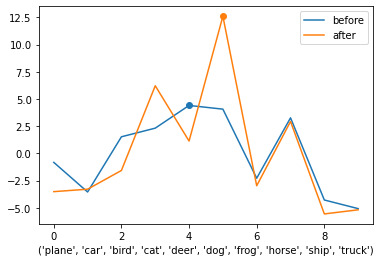

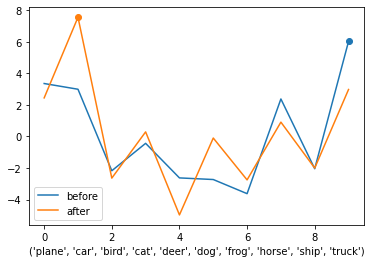

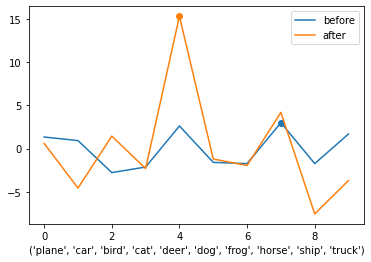

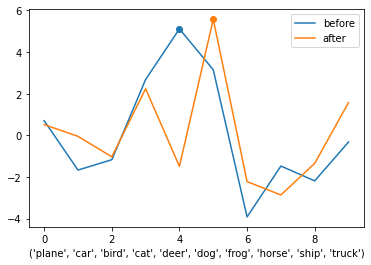

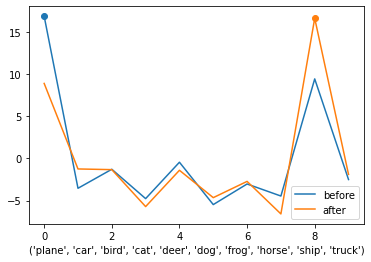

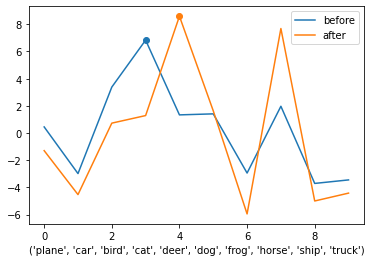

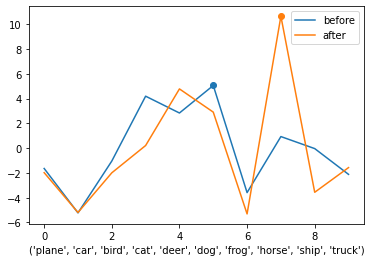

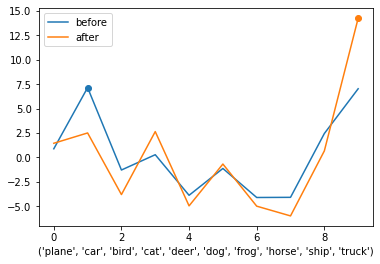

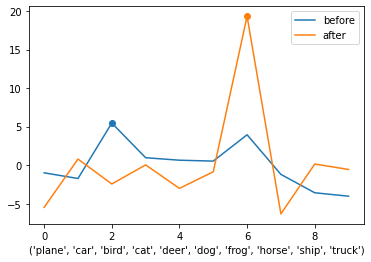

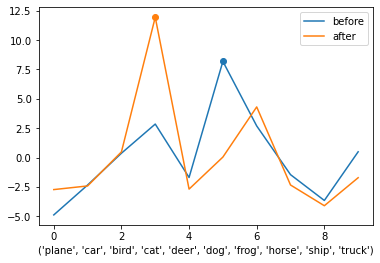

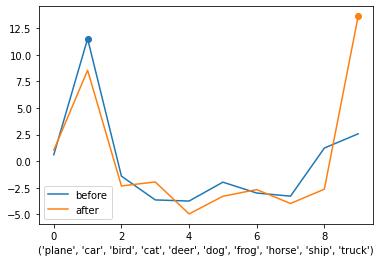

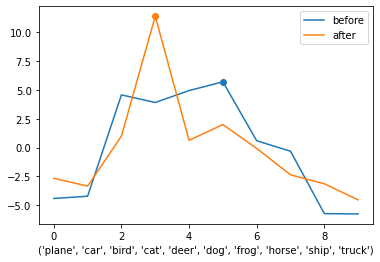

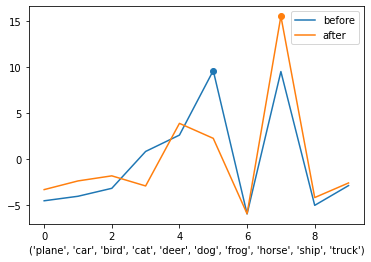

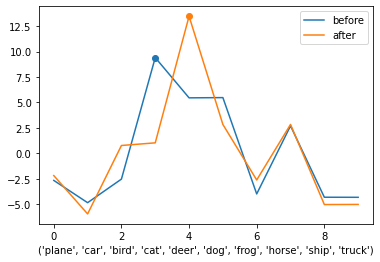

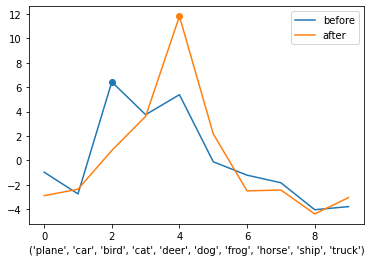

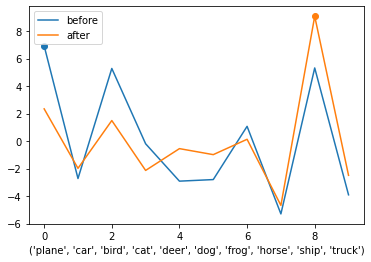

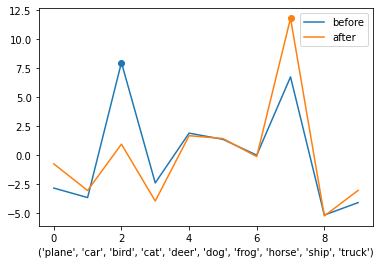

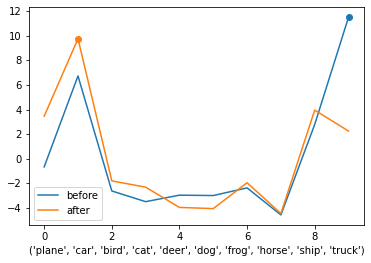

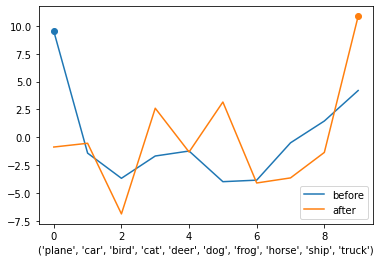

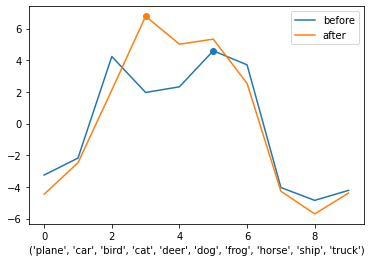

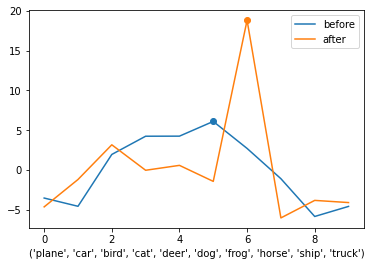

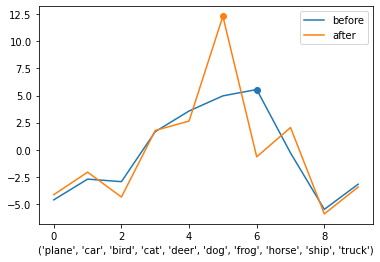

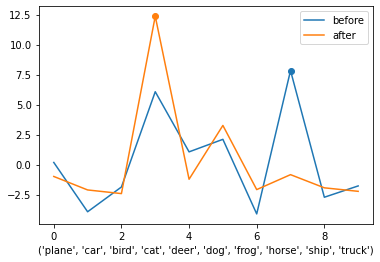

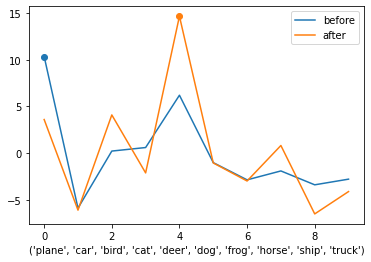

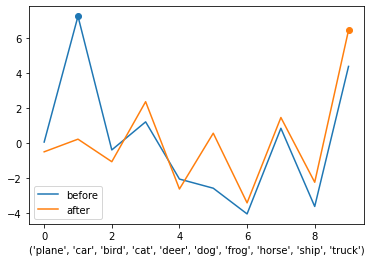

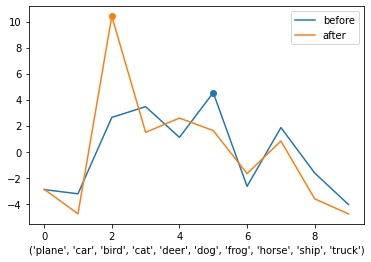

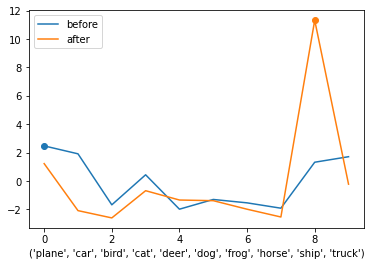

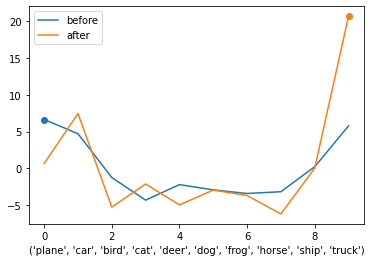

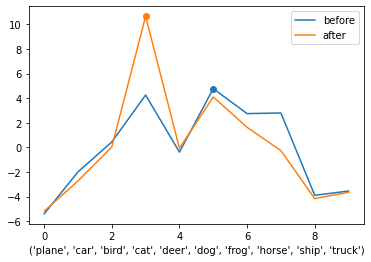

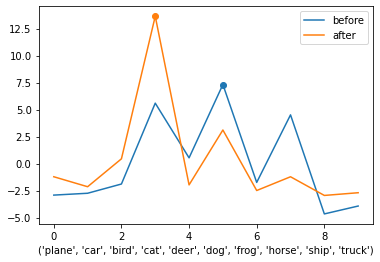

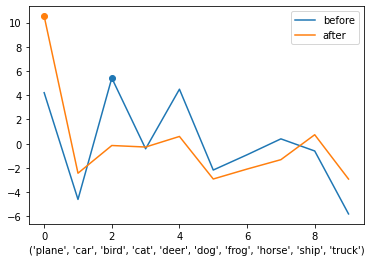

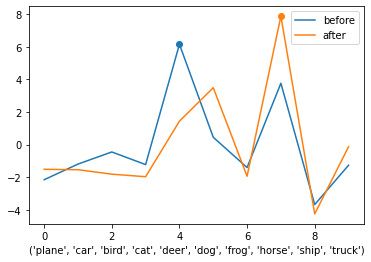

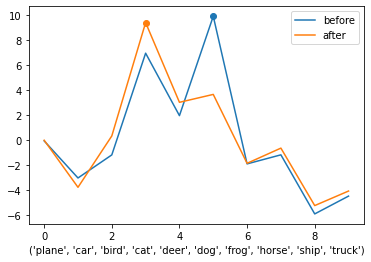

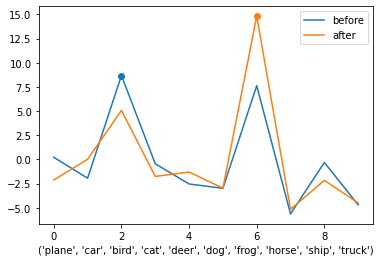

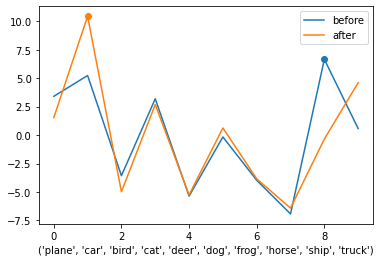

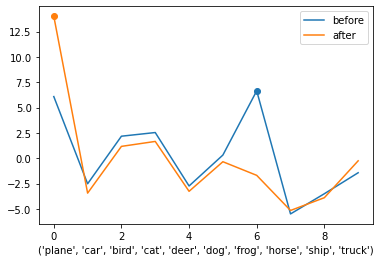

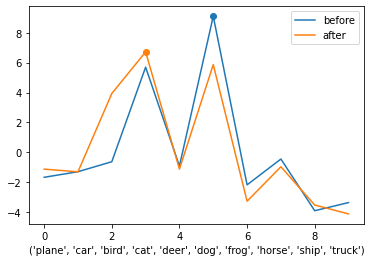

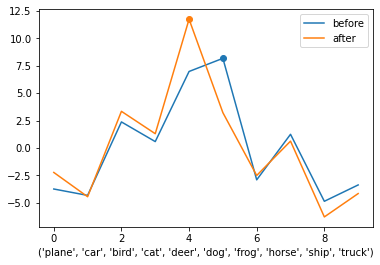

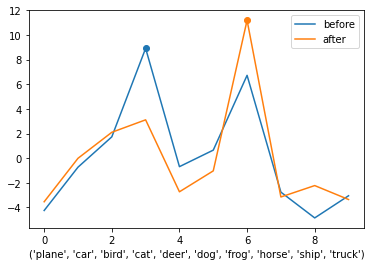

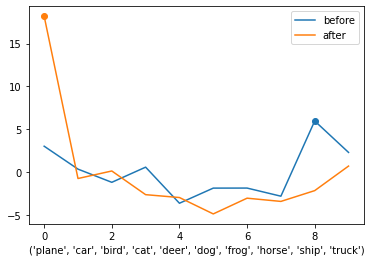

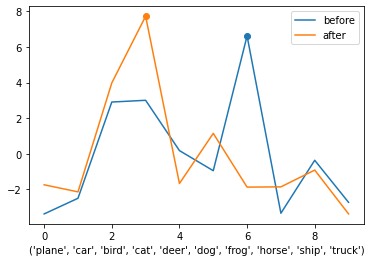

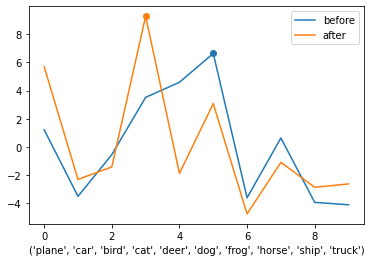

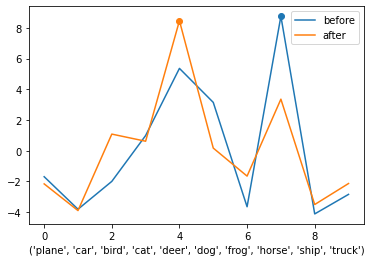

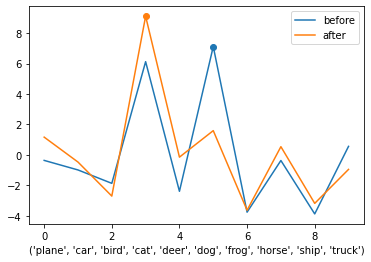

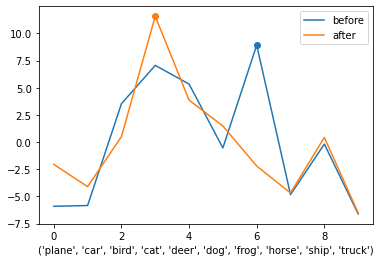

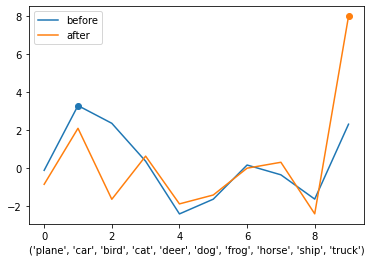

KeyboardInterrupt: 

In [64]:
for i in range(len(correct_dict['img_before'])):
    argmax = torch.argmax(correct_dict['softlabel_before'][i])
    plt.plot(correct_dict['softlabel_before'][i], label = 'before')
    plt.scatter(argmax, correct_dict['softlabel_before'][i][argmax])
    
    argmax = torch.argmax(correct_dict['softlabel_after'][i])
    plt.plot(correct_dict['softlabel_after'][i], label = 'after')
    plt.scatter(argmax, correct_dict['softlabel_after'][i][argmax])
    plt.legend()
    plt.xlabel(classes)
    plt.show()


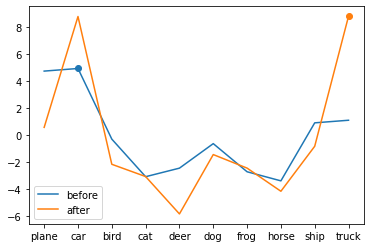

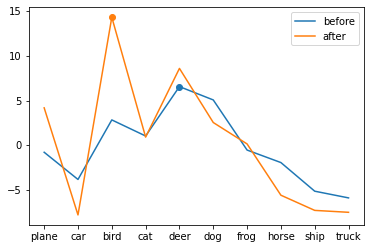

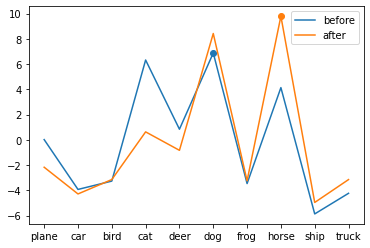

In [65]:
for i in range(len(uncorrect_dict['img_before'])):
    argmax = torch.argmax(uncorrect_dict['softlabel_before'][i])
    plt.plot(uncorrect_dict['softlabel_before'][i], label = 'before')
    plt.scatter(argmax, uncorrect_dict['softlabel_before'][i][argmax])
    
    argmax = torch.argmax(uncorrect_dict['softlabel_after'][i])
    plt.plot(uncorrect_dict['softlabel_after'][i], label = 'after')
    plt.scatter(argmax, uncorrect_dict['softlabel_after'][i][argmax])
    plt.legend()
    plt.xticks((0,1,2,3,4,5,6,7,8,9),classes)
    plt.show()


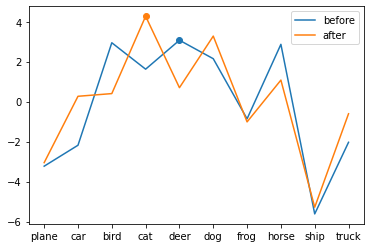

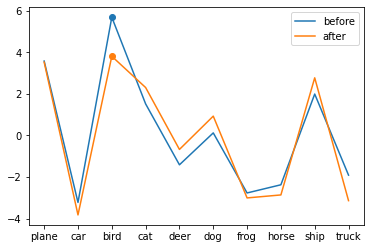

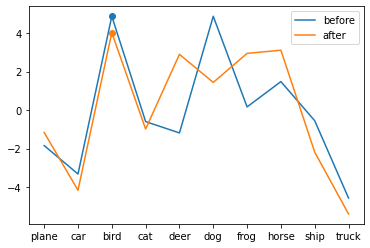

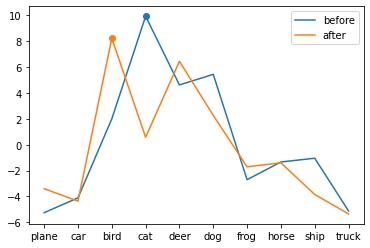

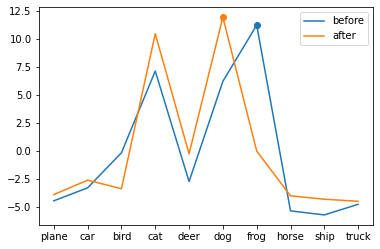

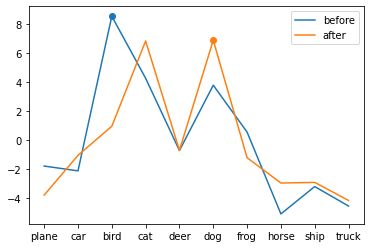

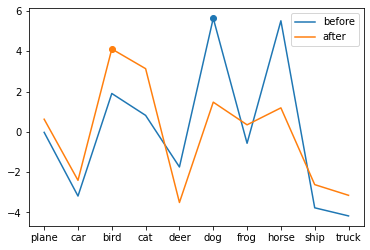

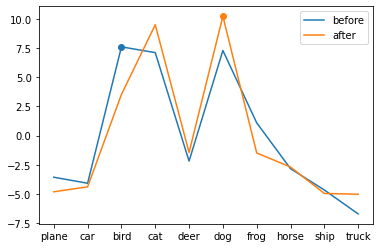

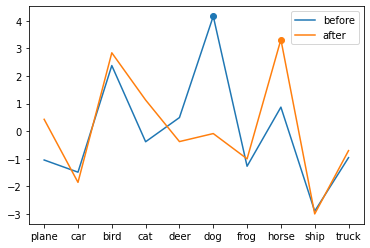

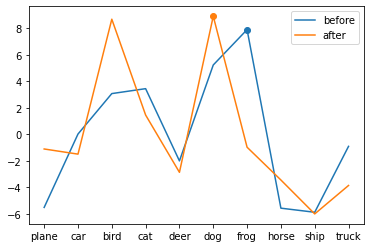

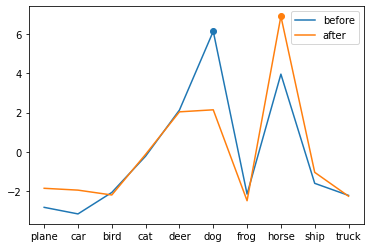

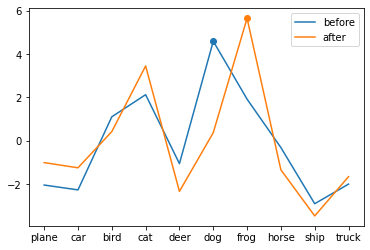

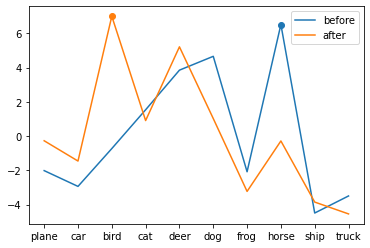

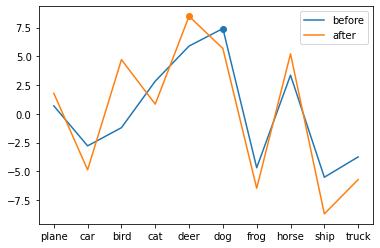

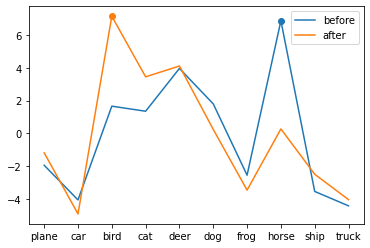

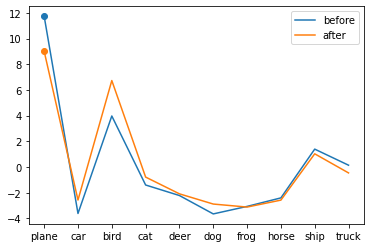

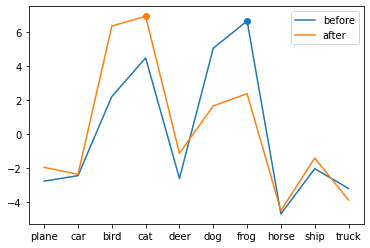

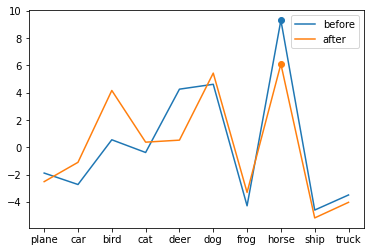

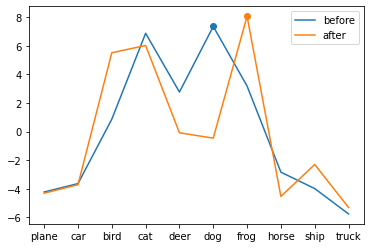

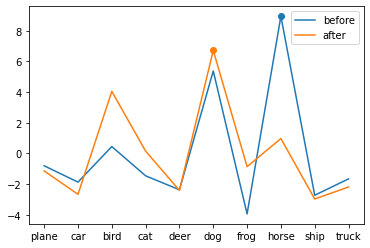

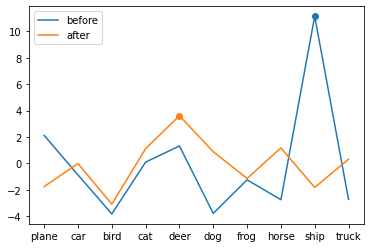

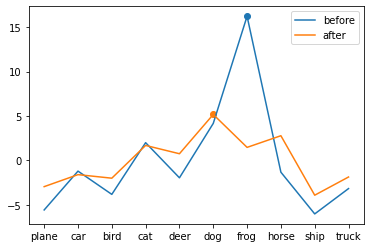

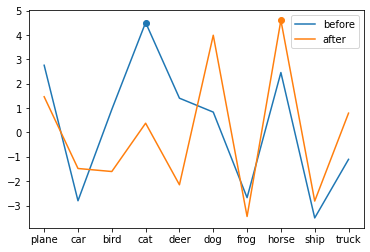

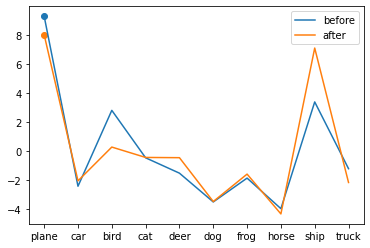

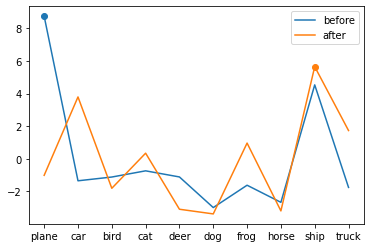

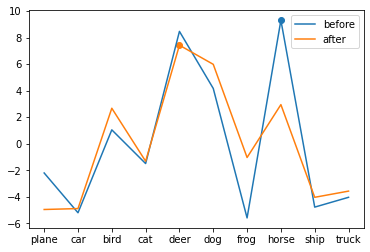

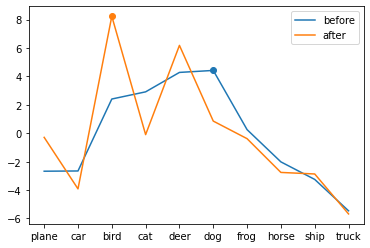

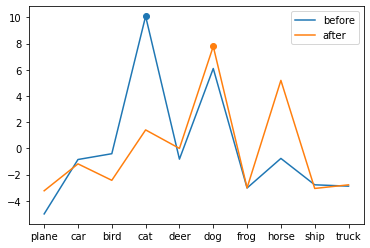

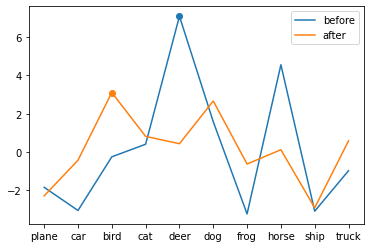

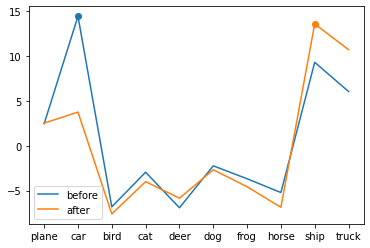

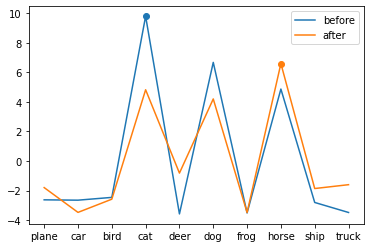

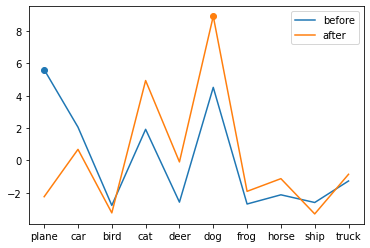

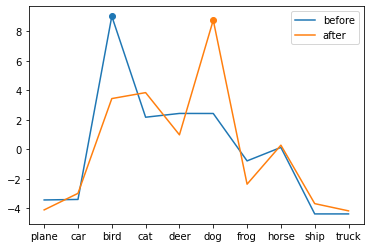

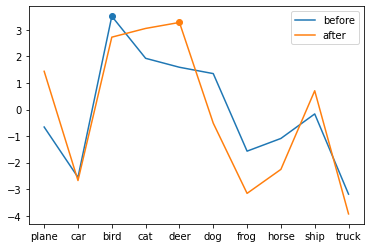

In [66]:
for i in range(len(uncorrect_sp_dict['img_before'])):
    argmax = torch.argmax(uncorrect_sp_dict['softlabel_before'][i])
    plt.plot(uncorrect_sp_dict['softlabel_before'][i], label = 'before')
    plt.scatter(argmax, uncorrect_sp_dict['softlabel_before'][i][argmax])
    
    argmax = torch.argmax(uncorrect_sp_dict['softlabel_after'][i])
    plt.plot(uncorrect_sp_dict['softlabel_after'][i], label = 'after')
    plt.scatter(argmax, uncorrect_sp_dict['softlabel_after'][i][argmax])
    plt.legend()
    plt.xticks((0,1,2,3,4,5,6,7,8,9),classes)
    plt.show()


## Img 변화

In [566]:
from matplotlib import pyplot as plt
def change_format(img):
    return torch.cat((img[2].unsqueeze(-1), img[1].unsqueeze(-1), img[0].unsqueeze(-1)), dim=-1)

def normalize(img):
    img -= torch.min(img)
    img /= (torch.max(img) + 0.01)
    img = img* 255
    return img.int()

# print(classes[label[idx].item()])



def draw_img(d, idx):

    label = torch.argmax(d['softlabel_before'][idx]).item()
    label2 = torch.argmax(d['softlabel_after'][idx]).item()
    print(classes[label] + "->" + classes[label2] +  f"({classes[d['real_label'][idx]]})")
    
    a, b, c = d['img_before'][idx], d['img_after'][idx], d['lrp'][idx]
    a_copy = a.clone()
    a = a - torch.min(a)
    a = a / torch.max(a)
    a = a * 255
    a = a.int()
    

    
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 3,1) 
    plt.title("original")
    plt.imshow(change_format(a).cpu().detach().numpy().reshape(224,224,3))

    plt.subplot(1, 3,2) 
    plt.title("original - lrp_img")
    plt.imshow(change_format(abs(a_copy - b) * 255).cpu().detach().numpy().reshape(224,224,3))
    
    plt.subplot(1, 3,3) 
    plt.title("lrp")
    c = normalize(c).float()
#     c = (normalize(torch.softmax(c)))
    plt.imshow(change_format(normalize((c > torch.mean(c)*1.1).float()).cpu()))
    plt.show()

def draw_plot(d, idx):
    plt.figure(figsize = (12, 12))
    argmax = torch.argmax(d['softlabel_before'][idx])
    plt.plot(d['softlabel_before'][idx], label = 'before')
    plt.scatter(argmax, d['softlabel_before'][idx][argmax])

    argmax = torch.argmax(d['softlabel_after'][idx])
    plt.plot(d['softlabel_after'][idx], label = 'after')
    plt.scatter(argmax, d['softlabel_after'][idx][argmax])
    plt.legend()
    plt.xticks((0,1,2,3,4,5,6,7,8,9),classes)
    plt.grid(True)
    plt.show()



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


plane->truck(truck)


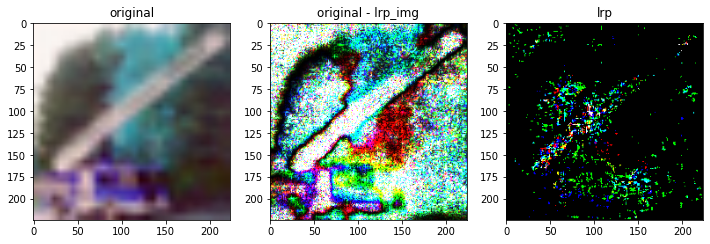

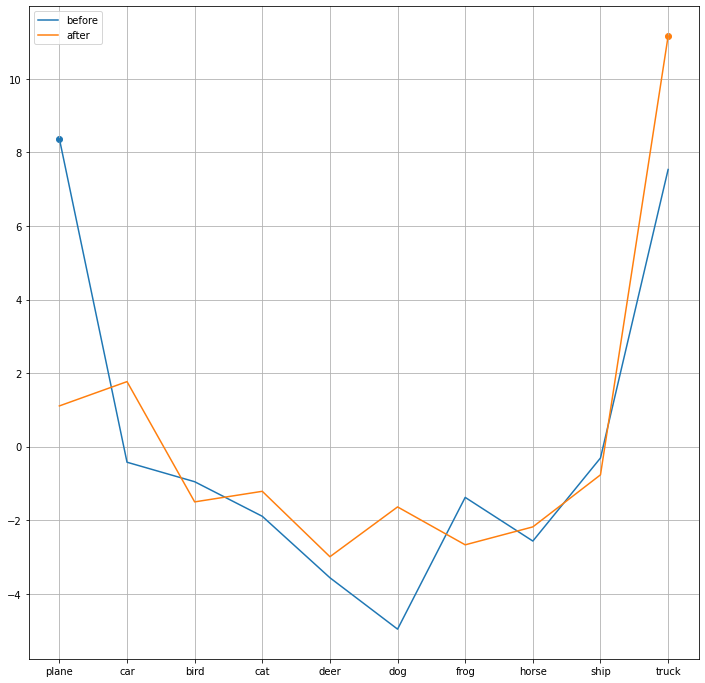

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog->cat(cat)


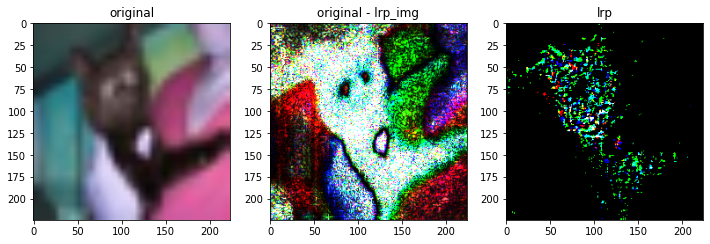

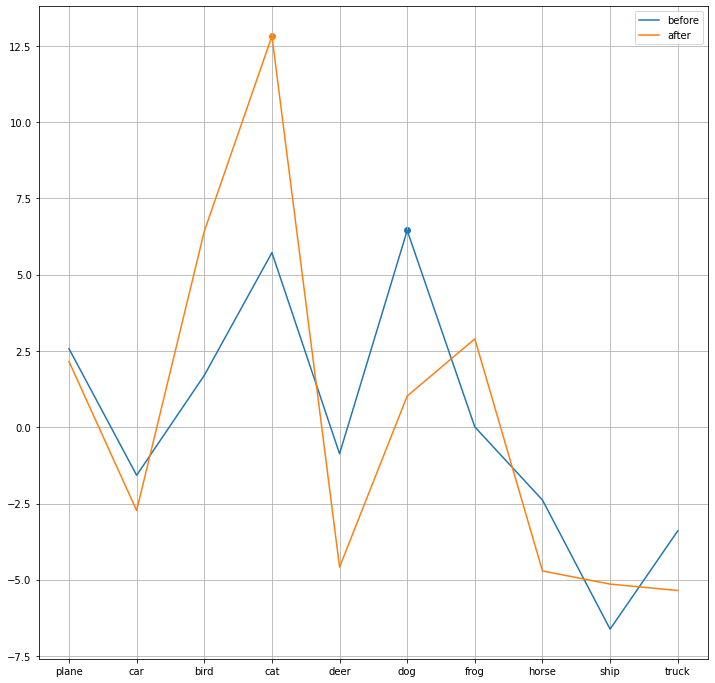

plane->truck(truck)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


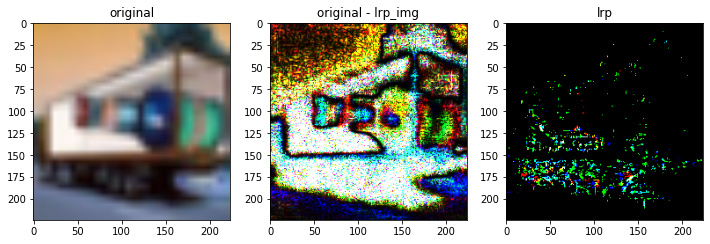

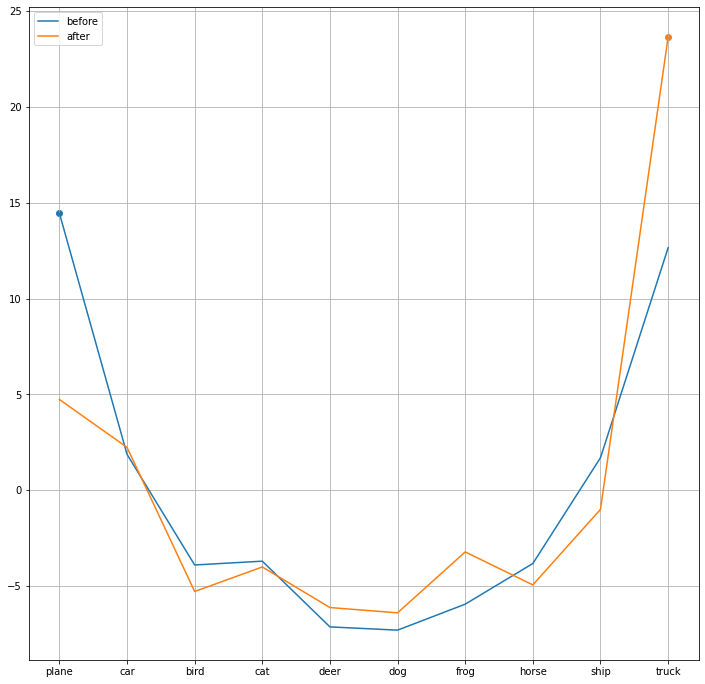

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck->car(car)


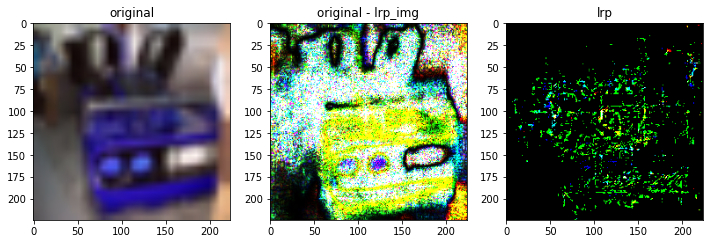

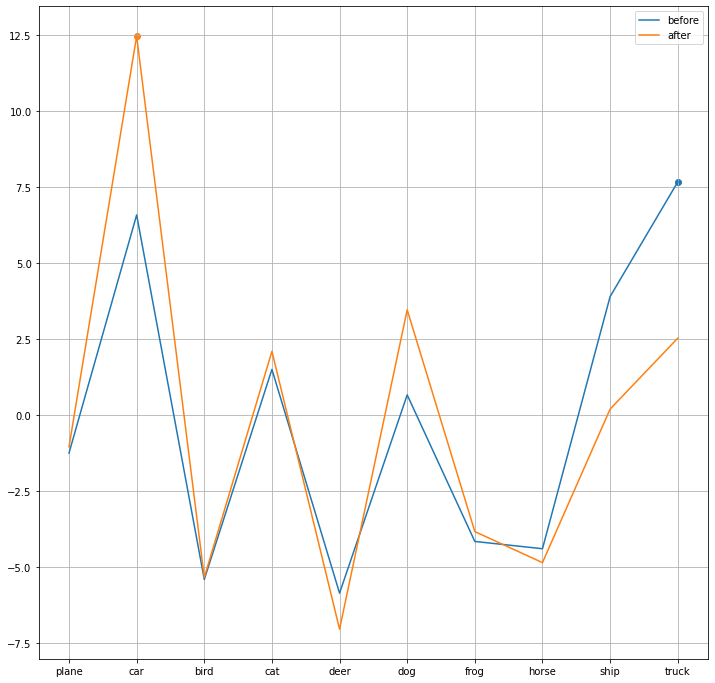

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse->deer(deer)


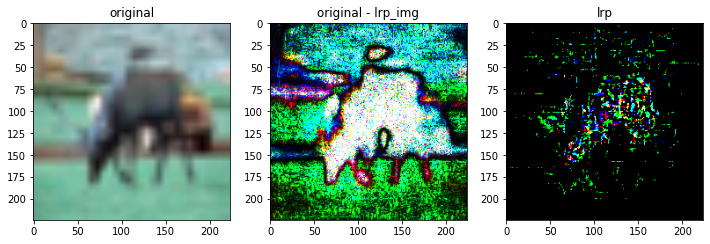

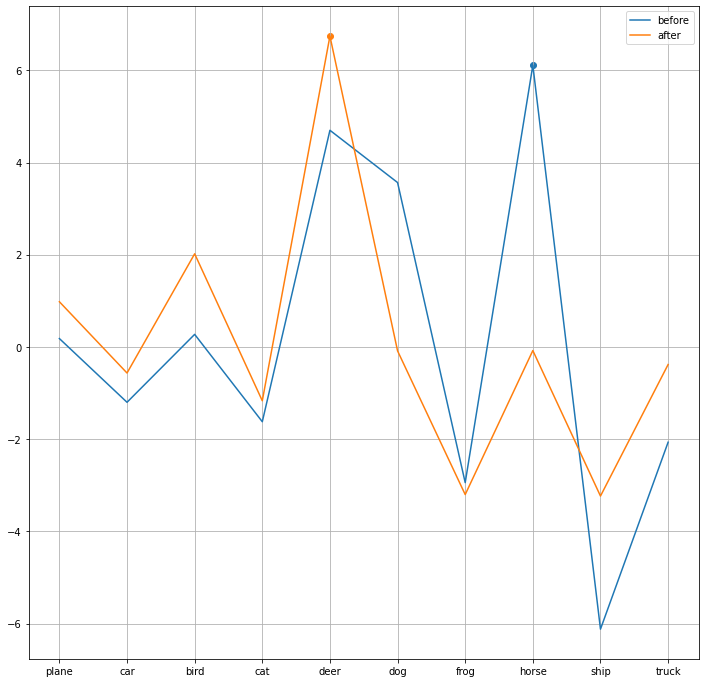

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse->cat(cat)


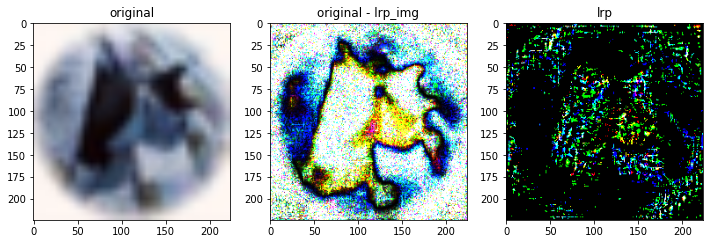

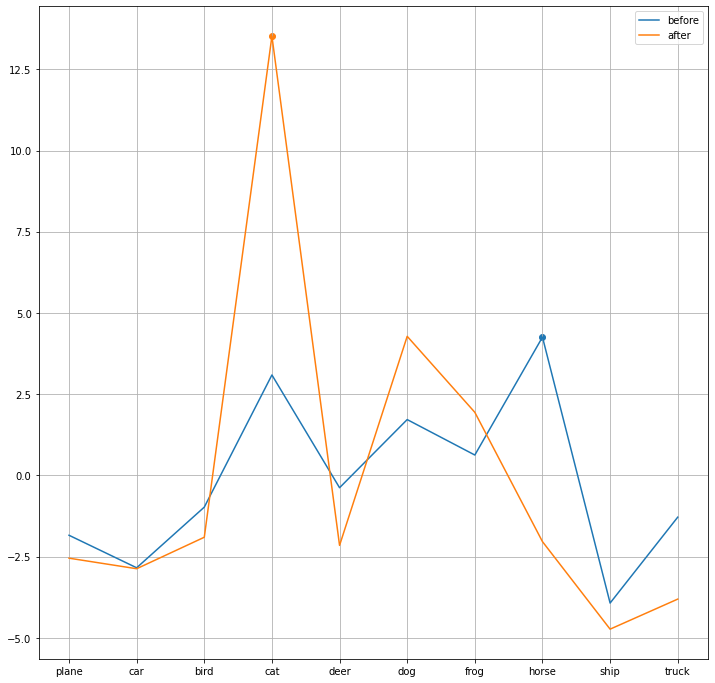

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog->horse(horse)


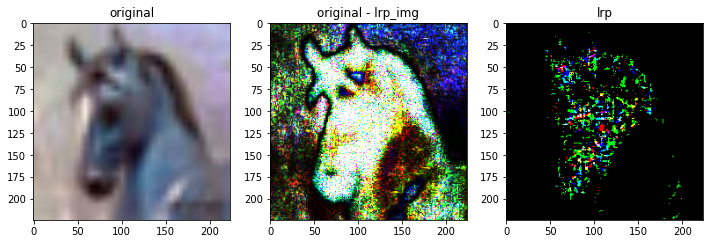

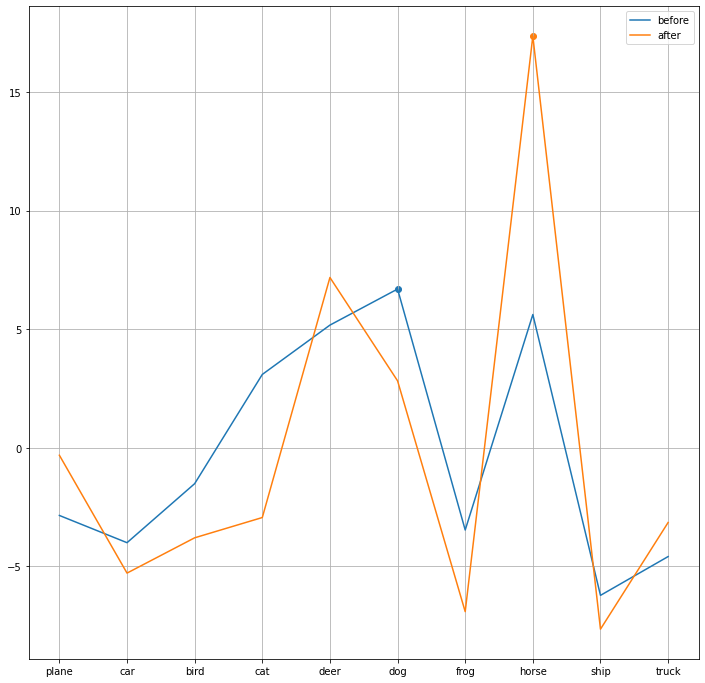

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


horse->plane(plane)


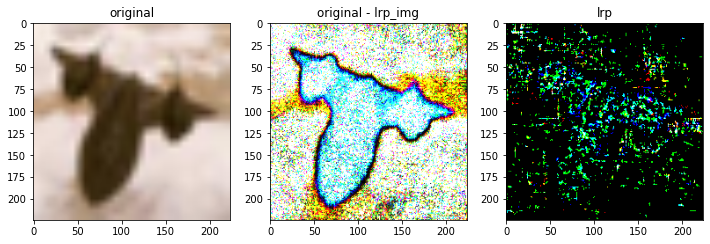

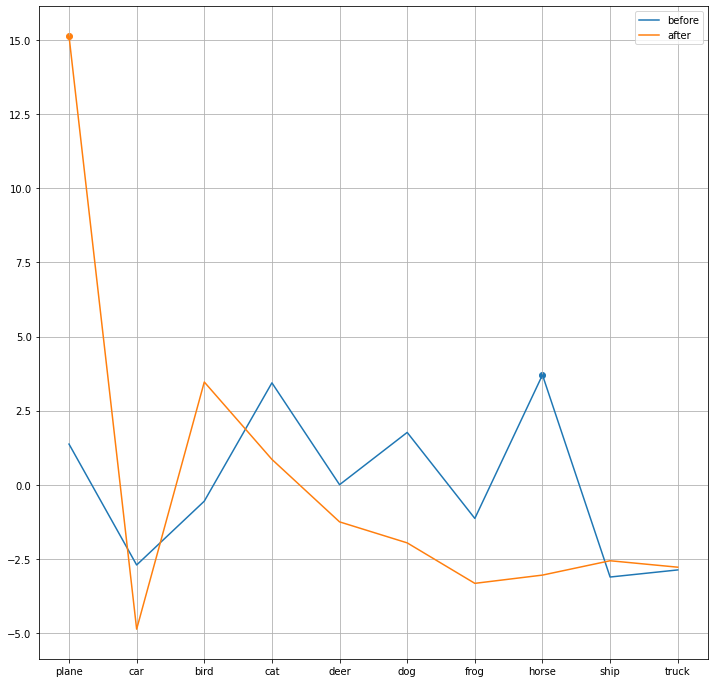

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog->frog(frog)


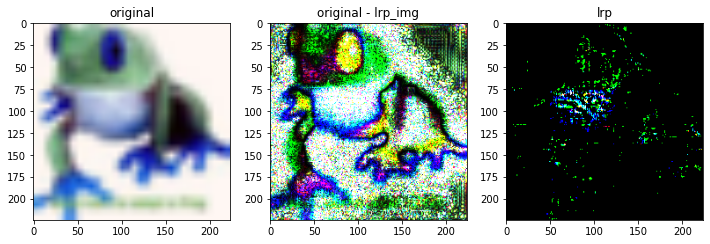

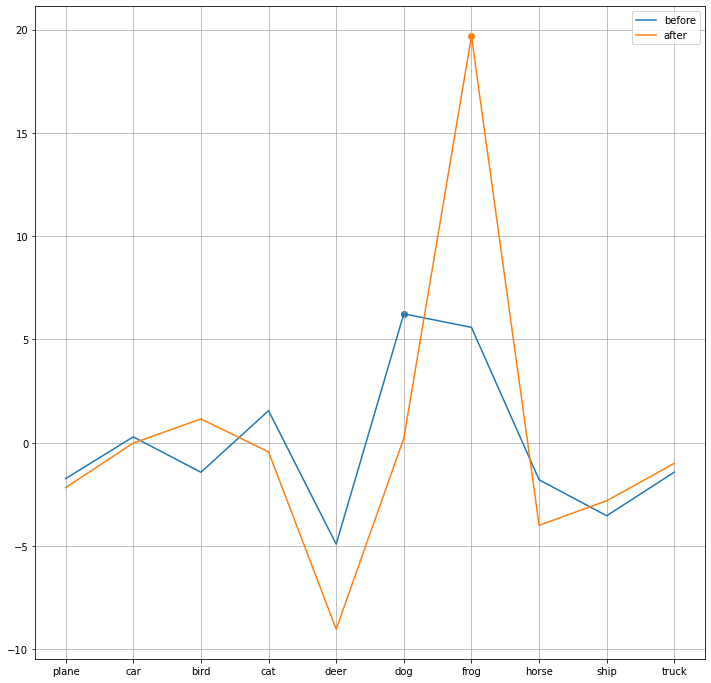

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog->cat(cat)


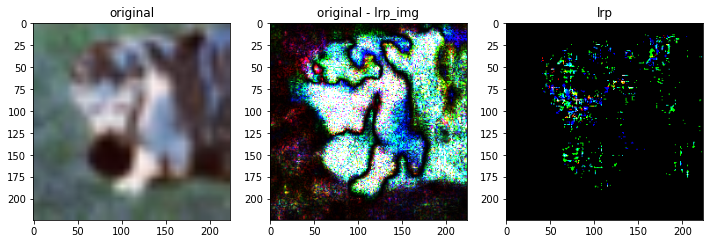

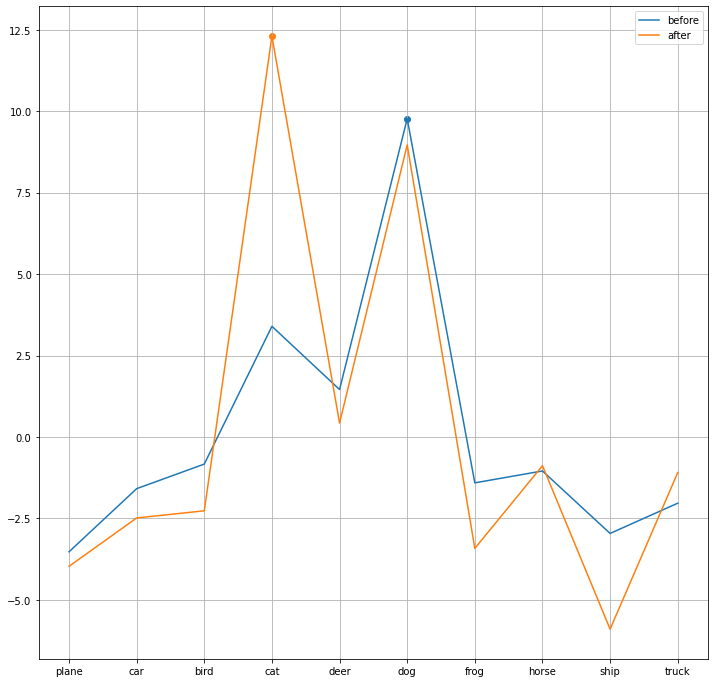

In [571]:
for idx in range(10):
#     idx = 5
    draw_img(correct_dict, idx)
    draw_plot(correct_dict, idx)



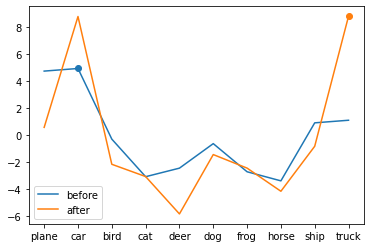

In [171]:
argmax = torch.argmax(uncorrect_dict["softlabel_before"][idx])
plt.plot(uncorrect_dict["softlabel_before"][idx], label="before")
plt.scatter(argmax, uncorrect_dict["softlabel_before"][idx][argmax])

argmax = torch.argmax(uncorrect_dict["softlabel_after"][idx])
plt.plot(uncorrect_dict["softlabel_after"][idx], label="after")
plt.scatter(argmax, uncorrect_dict["softlabel_after"][idx][argmax])
plt.legend()
plt.xticks((0, 1, 2, 3, 4, 5, 6, 7, 8, 9), classes)
plt.show()

In [527]:
a, b, c = correct_dict['img_before'][idx], correct_dict['img_after'][idx], correct_dict['lrp'][idx]

# c = (normalize((c*100) ** 2))

In [525]:
torch.std(\
    normalize((normalize(c)).float()).float()\
         )

tensor(5.6510, device='cuda:0')

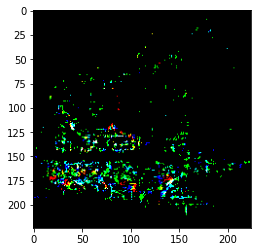

In [532]:
plt.imshow(change_format(normalize((c > torch.mean(c)*1.1).float()).cpu()))

In [530]:
c > torch.mean(c)

tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [False,  True, False,  ..., False, False,  True],
         ...,
         [False, False,  True,  ..., False, False, False],
         [False, False,  True,  ...,  True, False, False],
         [False, False,  True,  ...,  True,  True,  True]],

        [[ True, False, False,  ..., False, False, False],
         [False, False, False,  ...,  True,  True,  True],
         [False, False, False,  ...,  True,  True,  True],
         ...,
         [ True,  True,  True,  ..., False,  True,  True],
         [False,  True, False,  ..., False, False, False],
         [False,  True, False,  ..., False, False, False]],

        [[ True,  True,  True,  ..., False, False,  True],
         [ True, False, False,  ..., False, False,  True],
         [ True, False, False,  ..., False,  True,  True],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [